###  Cauchy 1D Inference Problem

Solve: $$y''(t) + 2y'(t) + y(t) = e^{-t}cos(2t)$$
For $t>0$ and with initial conditions:
$$y(0) = 1, \; y'(0) = -1$$
The exact solution is $$y(t) = -\frac{1}{4} e^{-t} (cos(2  t) - 5)$$

***

We will assume $t \in [0,15]$.<br>
$N_u = 1$ our training data ($y(0) = 1 , y'(0) = -1$) and $N_f = 10000$ our collocations points ($t_i \in [0,10]$ for $i=0,1,...,9999$). <br>
NN input is $t$, size 1. <br>
NN output is $y(t)$, size 1. <br>
We will use 9 hidden layers with 20 nodes and tanh as activation function.<br>  
For regularization define: $f = y''(t) + 2y'(t) + y(t) - e^{-t}cos(2t)$

### Data Generation

In [11]:
import numpy as np 
def exact_y(t):
    return -1.0/4 * np.exp(-t)*(np.cos(2*t)-5)

def exact_yt(t):
    return 1.0/4 * np.exp(-t) * (2*np.sin(2*t)+np.cos(2*t)-5)

def exact_ytt(t):
    return 1.0/4 * np.exp(-t) * (-4*np.sin(2*t) + 3*np.cos(2*t)+5)


def exact_de(t):
    return np.exp(-t)*np.cos(2*t)

# generating colocation points
import random
random.seed(1)
lower_bound = 0
upper_bound = 15
N_f = 1000
t_f = [random.uniform(lower_bound,upper_bound) for _ in range(N_f)]

# generate points for initial conditions
N_u = 1
t_u = np.array([0.0])
y_u = 1
yt_u = -1


# points for accurate evaluations
N_eval = 1000
lower_bound = 0
upper_bound = 15
t_exact = np.linspace(lower_bound,upper_bound,N_eval).reshape(1,-1).T

y_exact = exact_y(t_exact).reshape(1,-1).T #exact y(t)

### PINN Architecture

In [12]:
import torch
from torch import nn 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 

        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, 20)
        self.fc7 = nn.Linear(20, 20)
        self.fc8 = nn.Linear(20, 20)
        self.fc9 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        return x


net = Net()
print(net)

params = list(net.parameters())
#print(len(params))
for par in params:
    print(par.shape)

Net(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=20, bias=True)
  (fc7): Linear(in_features=20, out_features=20, bias=True)
  (fc8): Linear(in_features=20, out_features=20, bias=True)
  (fc9): Linear(in_features=20, out_features=1, bias=True)
)
torch.Size([20, 1])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


### PINN train and loss definition

In [13]:
import torch.optim as optim
import numpy as np

class PINN():
    def __init__(self, t_u, y_u, yt_u, t_f, max_iter=1000):
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"device used: {self.device}")
        self.t_u = torch.tensor(t_u, requires_grad=True).reshape(1, -1).T.float().to(self.device)
        self.t_f = torch.tensor(t_f, requires_grad=True).reshape(1, -1).T.float().to(self.device)
        self.y_u = torch.tensor(y_u).float().to(self.device)
        self.yt_u = torch.tensor(yt_u).float().to(self.device)
        
        self.net = Net().to(self.device)
        
        self.optimizer = optim.Adam(self.net.parameters())
        
        self.max_iter = max_iter

        self.iter = 0
        
    def net_y(self,t): #get y(t) for a t; a forward pass through the PINN
        y = self.net(t)
        return y
   
    def net_yt(self, t):
        y = self.net_y(t)
        yt = torch.autograd.grad( #first partial derivative with respect to t
            y, t, 
            grad_outputs=torch.ones_like(y),
            retain_graph=True,
            create_graph=True
        )[0]
        return yt
    
    def net_ytt(self, t):
        y = self.net_y(t)
        yt = torch.autograd.grad( #first partial derivative with respect to t
            y, t, 
            grad_outputs=torch.ones_like(y),
            retain_graph=True,
            create_graph=True
        )[0]
        ytt = torch.autograd.grad( #second partial derivative with respect to t
            yt, t, 
            grad_outputs=torch.ones_like(yt),
            retain_graph=True,
            create_graph=True
        )[0]
        return ytt
        
    
    def net_f(self, t): #get f = ytt + 2 * yt + y - exp(-t)cos(2t)
        y = self.net_y(t)
        yt = torch.autograd.grad( #first partial derivative with respect to t
            y, t, 
            grad_outputs=torch.ones_like(y),
            retain_graph=True,
            create_graph=True
        )[0]
        ytt = torch.autograd.grad( #second partial derivative with respect to t
            yt, t, 
            grad_outputs=torch.ones_like(yt),
            retain_graph=True,
            create_graph=True
        )[0]
        f = ytt + 2 * yt + y - torch.exp(-t) * torch.cos(2 * t)
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_u) 
        yt_pred = self.net_yt(self.t_u)
        f_pred = self.net_f(self.t_f) 
        loss_y = torch.mean((self.y_u - y_pred) ** 2) + torch.mean((self.yt_u - yt_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2) 
        
        loss = loss_y + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_y.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        for i in range(self.max_iter):
            self.net.train()
                
            # Backward and optimize
            self.optimizer.step(self.loss_func)

            
    def predict(self, t):
        self.net.eval()
        t_asTorch = torch.tensor(t, requires_grad=True).reshape(1, -1).T.float().to(self.device)
        y = self.net_y(t_asTorch) 
        y = y.detach().cpu().numpy()
        return y

### Training

In [ ]:
max_iter = 1000
model = PINN(t_u, y_u, yt_u, t_f)
model.train()

device used: cpu


### Relative error L2

In [5]:
y_pred = model.predict(t_exact) 

error_y = np.linalg.norm(y_exact-y_pred,2)/np.linalg.norm(y_exact,2) 
print('L2 Error y(t): %e' % (error_y))    

L2 Error y(t): 1.714918e-01


### Relative Error MSE

In [7]:
mse_y = ((y_exact - y_pred)**2).mean(axis=0) 

print('MSE Error y(t): %e' % (mse_y))   

MSE Error y(t): 1.275671e-03


### Plot

Text(0.5, 1.0, 'PINN Inference Performance y(t)')

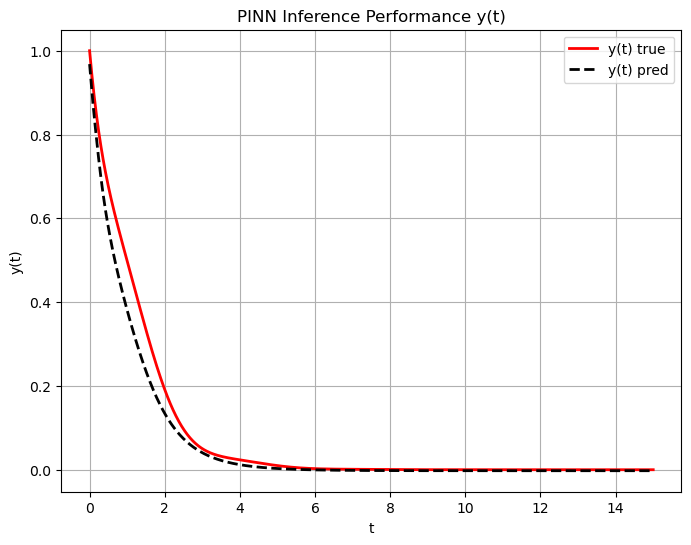

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(t_exact, y_exact, color="red", linewidth=2, label='y(t) true')
plt.plot(t_exact, y_pred, color="black",linestyle='--', linewidth=2, label='y(t) pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("PINN Inference Performance y(t)")